# Lab 5
Lucas Street, 1874989

In [10]:
%%capture
import sys
!{sys.executable} -m pip install --user scipy numpy matplotlib pandas pyuvdata
# Also install https://github.com/HERA-Team/hera_cal

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', size=22)
matplotlib.rc('figure', figsize=(18, 10))

import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats
from hera_cal.io import HERAData

The Hydrogen Epoch of Reionization Array (HERA) is an array of radio telescopes located in [South Africa](https://goo.gl/maps/44ntQEovA51L792m6). It is currently composed of 52 dishes, each 14 meters wide, packed in a hexagonal grid. The antenna in each dish measures an electromagnetic field over a certain amount of time, and since waves from distant sources are usually plane waves incident upon the telescope array at some angle, the signal reaches some telescopes before others. To reap the benefits of radio interferometry, the signals from any two telescopes are time-delayed such that they lie in the same time interval, then the data is correlated, Fourier-transformed, and averaged to view the frequency spectrum observed in that time interval. The pair of dishes composes a _baseline_, which is the displacement vector between the two dishes. 

In this data set, there are 52 active dishes, 1,378 baselines available to examine, and 60 time intervals for each baseline, with the data for each baseline-time having 1024 amplitudes for frequencies between 100 MHz and 200 MHz. There are also 4 polarizations of light to choose from: XX, XY, YX, and YY.

The units for each time interval value is given in Julian day numbers, the frequencies are given in Hertz, and the amplitude for each frequency is a complex value called the _interferometric visibility_.

In [11]:
filename = 'zen.2458108.57290.HH.uvh5'
hd = HERAData(filename)
print('antenna numbers:', sorted(hd.antenna_numbers))
print('antenna pairs:', len(hd.get_antpairs()))

antenna numbers: [0, 1, 2, 11, 12, 13, 14, 23, 24, 25, 26, 27, 36, 37, 38, 39, 40, 41, 50, 51, 52, 53, 54, 55, 65, 66, 67, 68, 69, 70, 71, 82, 83, 84, 85, 86, 87, 88, 98, 120, 121, 122, 123, 124, 136, 137, 138, 139, 140, 141, 142, 143]
antenna pairs: 1378


Next, I will define a few functions that will help us visualize the frequency spectra from these telescopes.

In [12]:
def get_spectrogram(hd, selected_times, freq_channels, *args, filter_dupes=False, **kwargs):
    hd.read(times=selected_times, freq_chans=freq_channels)
    if filter_dupes:
        pairs = np.array(hd.get_antpairs())
        no_dupe_pairs = pairs[pairs[:, 0] != pairs[:, 1]]
        hd.select(bls=list(map(tuple, no_dupe_pairs)))
    data = hd.get_data(*args, **kwargs)
    times = hd.get_times(*args, **kwargs)
    times -= times[0]
    freqs_mhz = hd.freq_array.flatten() / 1e6
    return pd.DataFrame(data, times, freqs_mhz), times, freqs_mhz

def plot_spectrogram(freqs, times, data, colorbar=True):
    # Handle case where we only have one unique time
    single_time = False
    if times[0] == times[-1]:
        single_time = True
        times = [0, 1]
    
    plt.imshow(np.abs(data), origin='bottom', extent=(freqs[0], freqs[-1], times[0], times[-1]), aspect='auto')
    
    if single_time:
        # No need for a time axis if we only have one time
        plt.gca().get_yaxis().set_visible(False)
    
    plt.ylabel('Time (JD)')
    plt.xlabel('Frequency (MHz)')
    if colorbar:
        cbar = plt.colorbar()
        cbar.set_label('Amplitude')
    
def plot_avg_amplitudes(freqs, times, data):
    avg_amplitudes = np.mean(np.abs(data), axis=0)
    plt.plot(freqs, avg_amplitudes)
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Amplitude')
    plt.xlim(freqs[0], freqs[-1])

Now we can view any frequency spectrum for any baseline, over any amount of time. Let's examine the frequency spectrum of XX-polarized light for the baseline composed of telescopes 0 and 1 for the first 10 time intervals:

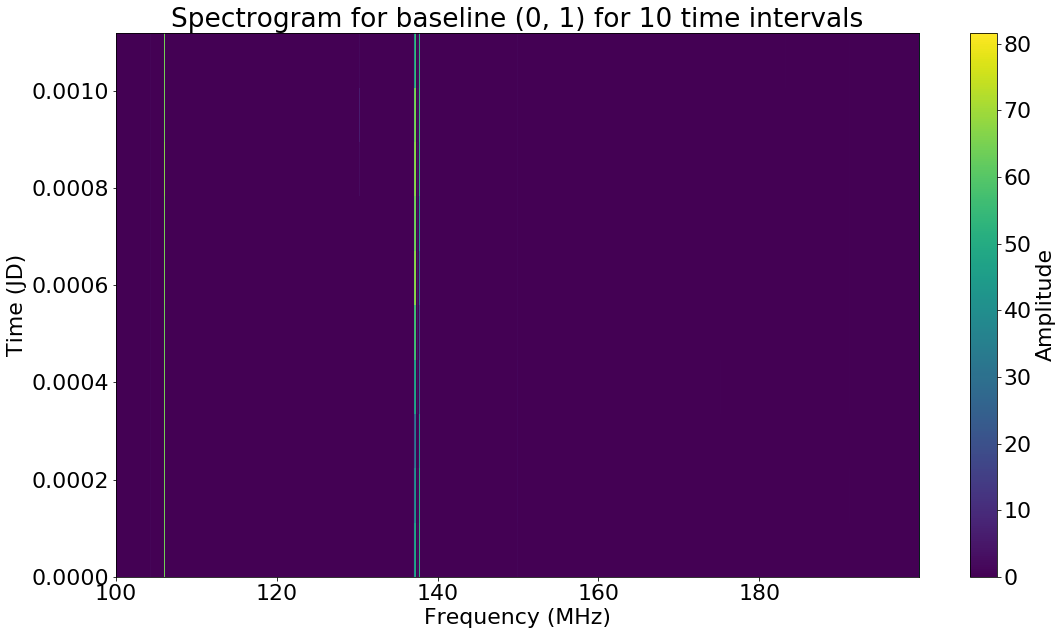

In [13]:
data, times, freqs_mhz = get_spectrogram(hd, hd.times[0:10], np.arange(0, 1024), 0, 1, 'XX')
plt.title('Spectrogram for baseline (0, 1) for 10 time intervals')
plot_spectrogram(freqs_mhz, times, data, colorbar=True)

The time axis starts at 0, which is taken to be the time at which the entire dataset begins. This data is interesting, but it's hard to be sure what exactly it tells us about what the array sees as a whole. 

Instead, let's stack the spectra of XX-polarized light for all 1,378 baselines in the first time interval on top of each other. Note that this is _not_ a spectrogram, just a big stack of individual spectra.

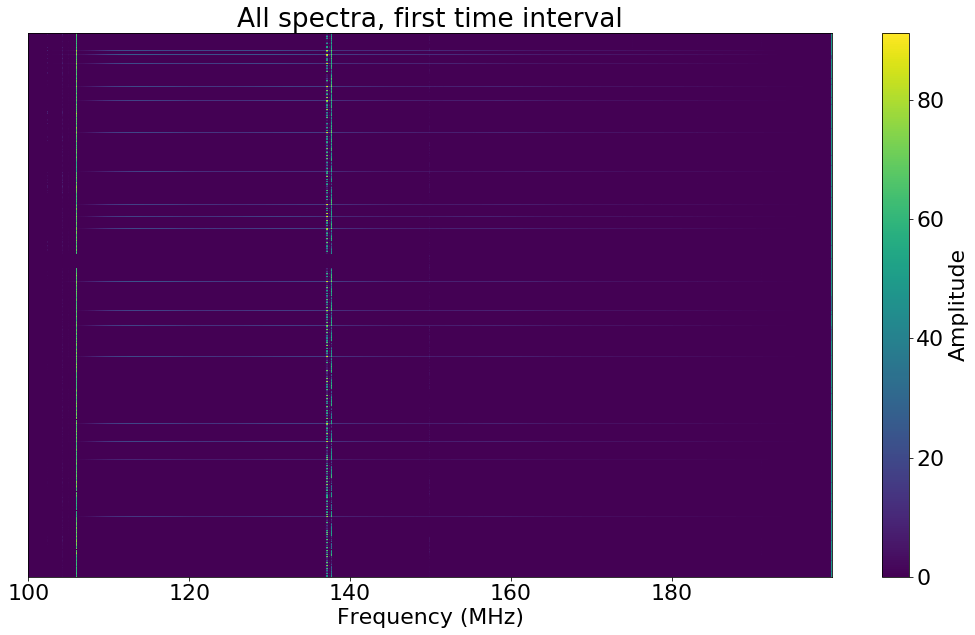

In [14]:
data, times, freqs_mhz = get_spectrogram(hd, hd.times[0:1], np.arange(0, 1024), 'XX')
plt.title('All spectra, first time interval')
plot_spectrogram(freqs_mhz, times, data, colorbar=True)

Most baselines seem to initially display about three main vertical lines as we saw in the previous plot. The leftmost line lies on the edge of the FM radio broadcast band, and the two rightmost lines lie in a range commonly used for space-to-Earth communications and weather/mobile satellites ([Source](https://www.jneuhaus.com/fccindex/30_mhz.html)). Upon closer inspection of this plot, it seems that some baselines contain data with 'streaks' across approximately 110-170 MHz, which is likely to be some kind of external interference (since few signals spread over so wide a range of frequencies). Let's plot the spectrum for one such baseline so we can 'zoom in' on one of these streaks.

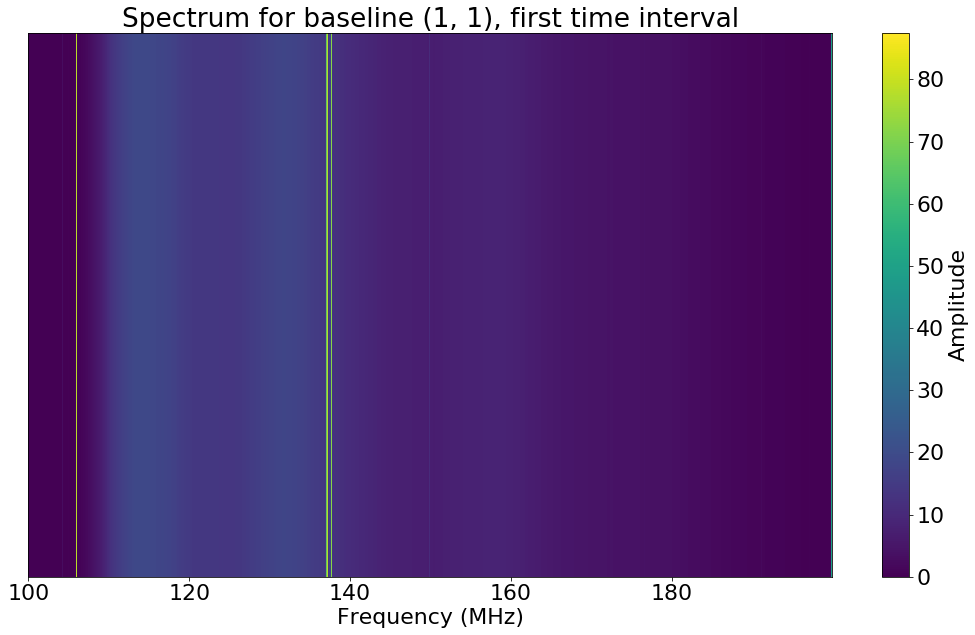

In [15]:
data, times, freqs_mhz = get_spectrogram(hd, hd.times[0:1], np.arange(0, 1024), 1, 1, 'XX')
plt.title('Spectrum for baseline (1, 1), first time interval')
plot_spectrogram(freqs_mhz, times, data, colorbar=True)

Notice that this spectrum comes from a baseline composed of a telescope and itself (a baseline of zero), so it fails to gain any benefit of using a radio interferometer. The result is that external interference is correlated together and effectively amplified in the resulting spectrum. We do not want this data, so we'll filter out all baselines composed of only one telescope.

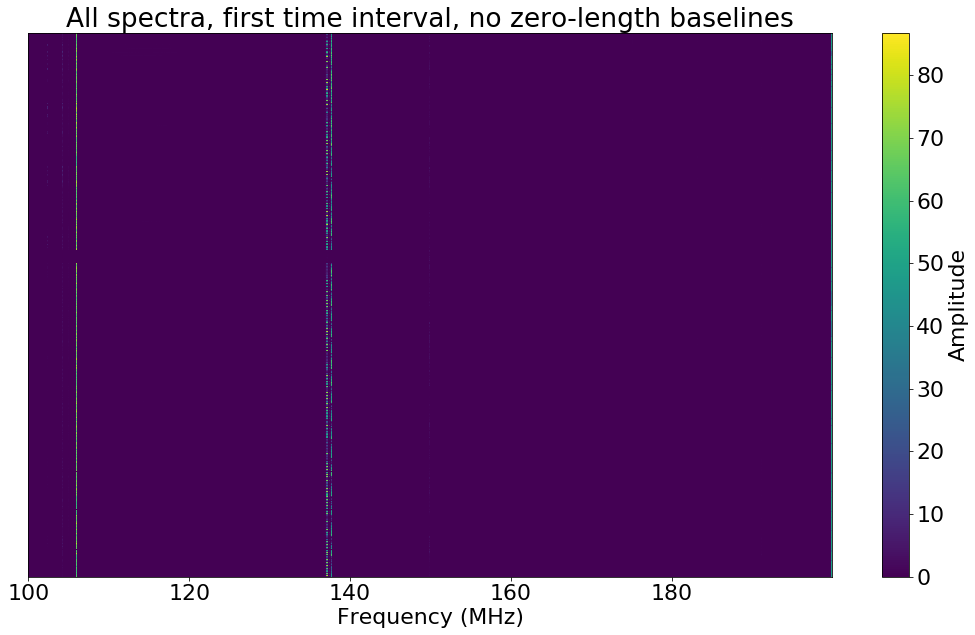

In [16]:
data, times, freqs_mhz = get_spectrogram(hd, hd.times[0:1], np.arange(0, 1024), 'XX', filter_dupes=True)
plt.title('All spectra, first time interval, no zero-length baselines')
plot_spectrogram(freqs_mhz, times, data, colorbar=True)

Much better. Now we've selected baselines that give us 'clean'-looking data. If we average together every spectrum shown above, we get the average amplitudes versus frequency, which allows us to get an idea of what the entire array sees during one time interval.

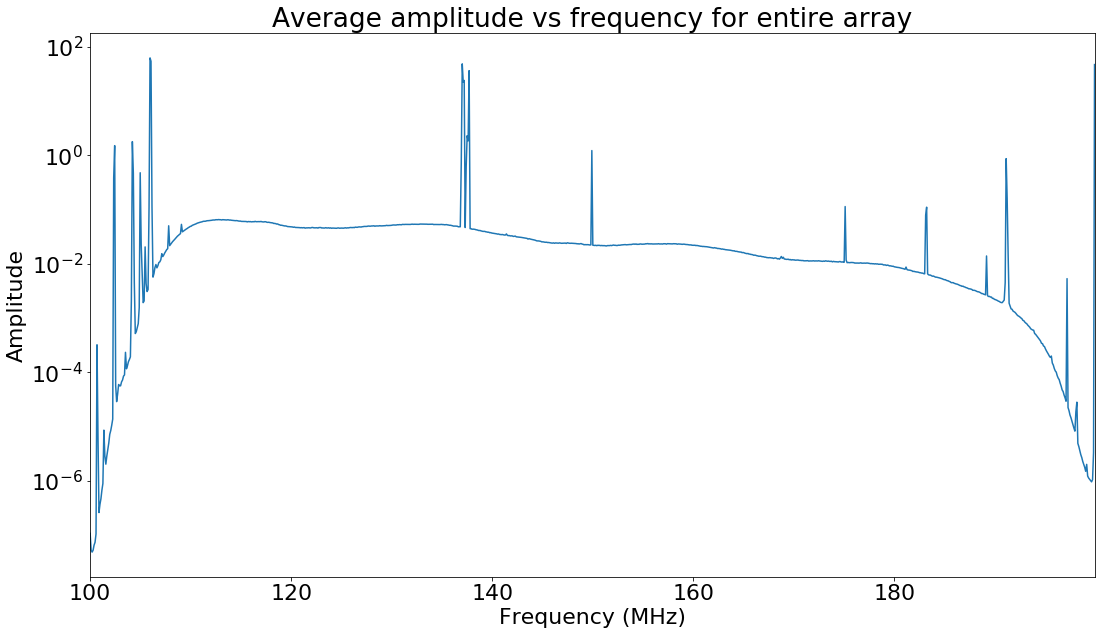

In [17]:
plot_avg_amplitudes(freqs_mhz, times, data)
plt.title('Average amplitude vs frequency for entire array')
plt.yscale('log')

This type of plot shows more frequency peaks, particularly in the FM radio broadcast band and several more peaks above ~170 MHz, each of which correspond to [television channel frequencies](https://en.wikipedia.org/wiki/Television_channel_frequencies#Western_Europe,_Greenland_and_most_countries_in_Asia,_Africa_and_Oceania) in South Africa. Aside from the peaks, there appears to be a steady background across the whole spectrum. It drops off at the left and right edges, but we can isolate most of the central plateau and plot a histogram of the amplitudes. Since the average background is definitely less than 1 unit of amplitude, we'll cut off the histogram at some small number, like 0.2 units, to ignore any extraneous signal.

Lognormal: mu: -0.0031863640447253906, sigma: 0.8366250744603609, s: 0.025341938321449015


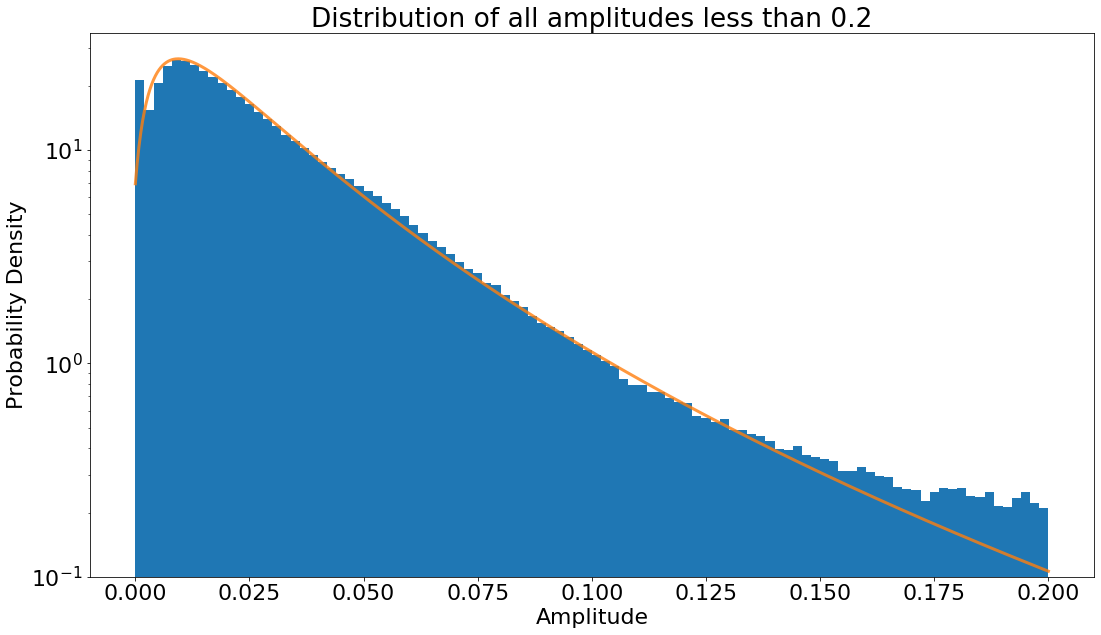

In [18]:
all_antenna_data, _, _ = get_spectrogram(hd, hd.times[0:1], np.arange(100, 800), 'XX')
hist_data = np.abs(np.array(all_antenna_data).flatten())
max_amplitude = 0.2
hist_data = hist_data[hist_data < max_amplitude]
# print(len(hist_data))
plt.title(f"Distribution of all amplitudes less than {max_amplitude}")
plt.xlabel('Amplitude')
plt.ylabel('Probability Density')
plt.hist(hist_data, bins=100, density=True);

sigma, mean, scale = stats.lognorm.fit(hist_data[0:900_000])
dist = stats.lognorm(sigma, mean, scale)
x = np.linspace(0, 0.2, 1000)
y = dist.pdf(x)
plt.plot(x, y, linewidth=3, alpha=0.8)
plt.yscale('log')
plt.ylim(1e-1)
print(f"Lognormal: mu: {mean}, sigma: {sigma}, s: {scale}")

After trying to fit several types of distributions, I found that a lognormal distribution seems to fit the data fairly well, at least for the portion of the histogram less than 0.1 or so. For parameters $\mu, \sigma, s$ printed above the plot, the lognormal PDF is given by $P(x|\mu, \sigma, s) = \frac{1}{\sigma x s \sqrt{2\pi}} \exp\left({-\frac{\log^2\left({\frac{x - \mu}{s}}\right)}{2\sigma^2}}\right)$